# Fully combined approach - fast tutorial

search for optimal hyperparameters and compare optimal coefficients with previous ones

In [1]:
import pandas
import os
import numpy as np
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')

from MDRefine import load_data, minimizer, hyper_minimizer

### Load data

In [3]:
infos = {'global': {
    'path_directory': '../../DATA',
    'system_names': ['AAAA', 'CCCC', 'GACC', 'UUUU', 'UCAAUC'], # CAAU
    'g_exp': ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs', ('uNOEs', '<')],
    'forward_qs': ['backbone1_gamma', 'backbone2_beta_epsilon','sugar'],
    'obs': ['NOEs', 'uNOEs'],
    'forward_coeffs': 'original_fm_coeffs'}}

stride = 100

In [33]:
import inspect

def sample_function(a, b, c=5):
    return a + b + c

params = inspect.signature(sample_function).parameters
print("Number of arguments:", len(params))

Number of arguments: 3


In [35]:
def forward_model_fun(fm_coeffs, forward_qs):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # # if you have selected_obs, compute only the corresponding observables
    # if selected_obs is not None:
    #     for type_name in forward_qs.keys():
    #         forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [36]:
params = inspect.signature(forward_model_fun).parameters
print("Number of arguments:", len(params))

if len(params) == 2:
    

params

Number of arguments: 2


mappingproxy({'fm_coeffs': <Parameter "fm_coeffs">,
              'forward_qs': <Parameter "forward_qs">})

In [37]:
def my_func(a, b, c=None):
    if c is not None:
        return my_func_input(a, b)
    else:
        return a + b + c

In [ ]:
my_func_input(a, b):

In [31]:
def my_func(a, b):
    return a + b

In [32]:
my_func(**)

SyntaxError: invalid syntax (<ipython-input-32-97dbf1df63ca>, line 1)

In [4]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs=None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [5]:
infos['global']['forward_model'] = forward_model_fun

choose among force-field correction on $\alpha,\zeta$ or only on $\alpha$ dihedral angles 

In [6]:
infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha', 'sin zeta', 'cos zeta']

def ff_correction(pars, f):
    out = jnp.matmul(pars, (f[:,[0,6,3,9]]+f[:,[1,7,4,10]]+f[:,[2,8,5,11]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:,[0,10,5,15]]+f[:,[1,11,6,16]]+f[:,[2,12,7,17]]+f[:,[3,13,8,18]]+f[:,[4,14,9,19]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [7]:
infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha']

def ff_correction(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 6]] + f[:, [1, 7]] + f[:, [2, 8]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 10]] + f[:, [1, 11]] + f[:, [2, 12]] + f[:, [3, 13]] + f[:, [4, 14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [9]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
loading  CCCC
loading  GACC
loading  UUUU
loading  UCAAUC
done


In [28]:
def forward_model_regularization(coeffs,coeffs_0):
    regularization = (
    3/8*(coeffs[0]-coeffs_0['A_gamma'])**2+1/2*(coeffs[1]-coeffs_0['B_gamma'])**2+(coeffs[2]-coeffs_0['C_gamma'])**2+(coeffs[0]-coeffs_0['A_gamma'])*(coeffs[2]-coeffs_0['C_gamma'])+
    3/8*(coeffs[3]-coeffs_0['A_beta'])**2+1/2*(coeffs[4]-coeffs_0['B_beta'])**2+(coeffs[5]-coeffs_0['C_beta'])**2+(coeffs[3]-coeffs_0['A_beta'])*(coeffs[5]-coeffs_0['C_beta'])+
    3/8*(coeffs[6]-coeffs_0['A_sugar'])**2+1/2*(coeffs[7]-coeffs_0['B_sugar'])**2+(coeffs[8]-coeffs_0['C_sugar'])**2+(coeffs[6]-coeffs_0['A_sugar'])*(coeffs[8]-coeffs_0['C_sugar']))

    return regularization

In [29]:
regularization = {'force_field_reg': 'KL divergence', 'forward_model_reg': forward_model_regularization}

### Case 1: ensemble + forward-model refinement
which_set = 'test'

random_states = 2

#### a. search for optimal hyperparameters

In [14]:
starting_alpha = np.inf#1
starting_beta = 1#np.inf
starting_gamma = np.inf

which_set = 'test'
random_states = 2

which_set = 'validation' (new frames) or 'test' (new observables); 'validation' by default

In [15]:
hyper_out = hyper_minimizer(data, regularization=regularization, starting_alpha=starting_alpha,
    starting_beta=starting_beta, starting_gamma=starting_gamma, random_states=random_states,
    ftol=1e-5, gtol=1e-1, which_set=which_set)

Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('beta', 0.0)]
av. chi2:  1437.996169606296
av. gradient:  [2.1170455]

log10 hyperpars:  [('beta', -1.0)]
av. chi2:  1437.1699239215206
av. gradient:  [0.21107131]

log10 hyperpars:  [('beta', -1.1107419543638815)]
av. chi2:  1437.1492923736093
av. gradient:  [0.16355151]

log10 hyperpars:  [('beta', -1.4918887083653458)]
av. chi2:  1437.1077977787977
av. gradient:  [0.06798954]


In [48]:
hyper_out

          fun: DeviceArray(1615.14696255, dtype=float64)
     hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
 intermediate: <MDRefine.Functions.hyper_minimizer.<locals>.hyper_intermediate_class object at 0x7fb23e1ddc88>
          jac: array([0.02420162])
      message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
         nfev: 2
          nit: 1
         njev: 2
       status: 0
      success: True
            x: array([-1.])

In [65]:
opt_beta, opt_gamma = 10**hyper_out.x
opt_alpha = np.Inf

print(opt_alpha, opt_beta, opt_gamma)

inf 0.27240288041578564 0.3810886639292848


In [14]:
opt_alpha, opt_gamma = 10**hyper_out.x
opt_beta = np.inf

print(opt_alpha, opt_beta, opt_gamma)

ValueError: not enough values to unpack (expected 2, got 1)

In [104]:
opt_alpha, opt_beta = 10**np.array([1.6602592646792638, 0.18965754178601119])
opt_gamma = np.inf

print(opt_alpha, opt_beta, opt_gamma)

45.73611431242951 1.5475957977240775 inf


In [49]:
opt_beta = 10**hyper_out.x[0]

opt_alpha = np.inf
opt_gamma = np.inf

print(opt_beta)

0.1


#### b. search for optimal coefficients at determined hyperparameters

In [68]:
Result = minimizer(data, regularization=regularization, beta=opt_beta, gamma=opt_gamma)

New evaluation:
loss:  23007.702303922753
gradient:  [-5.42712453e+04 -4.28140625e+02  1.05598499e-01  1.79592086e-01
  4.57851441e-01 -5.44168097e+00 -5.76910218e+00 -4.42330892e+00
  1.27632698e+01 -3.47309669e+00  1.90330836e+01] 

New evaluation:
loss:  7797.158734985676
gradient:  [ 2.38634934e+03  3.00537800e+03 -2.60619008e-01 -3.13150838e-01
 -6.78964603e-01 -4.14590921e+00 -4.34823489e+00 -3.22010237e+00
  1.46979195e+01 -6.07620469e+00  1.69177656e+01] 

New evaluation:
loss:  303682.70168175735
gradient:  [ 2.07072761e+05 -2.67103636e+04  2.68255911e+00 -7.46043238e-01
  4.11539795e+00  2.48049970e+00  2.25508422e+00  8.53243902e+00
  1.47093579e+01 -7.94228185e+00  1.68947838e+01] 

New evaluation:
loss:  6750.280007873841
gradient:  [ 2.43079624e+03  3.84701143e+03 -2.21844367e-01 -2.67362819e-01
 -5.62170013e-01 -3.87193845e+00 -3.98339339e+00 -2.62368602e+00
  1.48623870e+01 -6.28571904e+00  1.68252512e+01] 

New evaluation:
loss:  5279.956689368934
gradient:  [ 1.720252

In [105]:
Result = minimizer(data, regularization=regularization, alpha=opt_alpha, beta=opt_beta, gamma=opt_gamma)

New evaluation:
loss:  232.7775063864291
gradient:  [-37.0212414    4.08287548] 

New evaluation:
loss:  245.3460714147288
gradient:  [29.0617649   3.33683677] 

New evaluation:
loss:  227.88673682104175
gradient:  [0.39361561 4.8087318 ] 

New evaluation:
loss:  227.0003255510407
gradient:  [14.92162039 -5.84433767] 

New evaluation:
loss:  225.32522774335138
gradient:  [5.35356064 2.72281764] 

New evaluation:
loss:  226.8390533430014
gradient:  [ 5.77921253 -5.89466781] 

New evaluation:
loss:  224.31325816571737
gradient:  [7.07773526 0.3337324 ] 

New evaluation:
loss:  224.1468880065155
gradient:  [ 0.51576118 -1.19788293] 

New evaluation:
loss:  224.09235389804087
gradient:  [-0.78172507  0.34893636] 

New evaluation:
loss:  224.08546209119567
gradient:  [0.05117922 0.00877776] 

New evaluation:
loss:  224.08545820981405
gradient:  [0.04739031 0.00068256] 

New evaluation:
loss:  224.08546098424165
gradient:  [0.04854637 0.00189173] 

New evaluation:
loss:  224.08546764980898
g

In [51]:
vars(Result)

{'loss': DeviceArray(3429.39647295, dtype=float64),
 'pars': array([ 0.94802089, -1.28500056]),
 'mini':       fun: 3429.3964729465342
  hess_inv: array([[1.78180286e-04, 1.04231095e-05],
        [1.04231095e-05, 6.10243317e-05]])
       jac: array([ 0.00023371, -0.00056039])
   message: 'Optimization terminated successfully.'
      nfev: 18
       nit: 10
      njev: 18
    status: 0
   success: True
         x: array([ 0.94802089, -1.28500056]),
 'intermediates': <MDRefine.Functions.intermediates_class at 0x7fb22c7e8940>,
 'time': 29.528476238250732,
 'reg_ff': {'AAAA': DeviceArray(0.63611044, dtype=float64),
  'CCCC': DeviceArray(0.91114824, dtype=float64),
  'GACC': DeviceArray(0.45171245, dtype=float64),
  'UUUU': DeviceArray(0.7842293, dtype=float64),
  'UCAAUC': DeviceArray(1.66568221, dtype=float64)},
 'av_g': {'AAAA': {'backbone1_gamma_3J': DeviceArray([2.21953091, 2.19665793, 1.86885024, 1.93176621, 1.94068822,
                1.82650163, 2.75439461, 1.82098704], dtype=float6

In [90]:
vars(Result).keys()

dict_keys(['loss', 'pars', 'mini', 'min_lambdas', 'minis', 'intermediates', 'time', 'reg_fm', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])

In [69]:
if not np.isinf(opt_beta):
    temp = infos['global']['names_ff_pars']
    my_ff_coeffs = pandas.Series(Result.pars[:len(temp)], index=temp)
    print(my_ff_coeffs)

if not np.isinf(opt_gamma):
    fm_names = ['A_gamma', 'B_gamma', 'C_gamma', 'A_beta', 'B_beta', 'C_beta', 'A_sugar', 'B_sugar', 'C_sugar']
    my_fm_coeffs = pandas.Series(Result.pars[-len(fm_names):], index=fm_names)
    print(my_fm_coeffs)

sin alpha    0.948543
cos alpha   -1.284926
dtype: float64
A_gamma     9.776437
B_gamma    -1.535660
C_gamma    -0.145552
A_beta     17.761679
B_beta     -5.362363
C_beta      0.171249
A_sugar     6.204327
B_sugar    -1.672162
C_sugar     1.090051
dtype: float64


In [69]:
def save_values(which_set, random_states, opt_alpha=np.inf, opt_beta=np.inf, opt_gamma=np.inf, my_fm_coeffs=None, my_ff_coeffs=None):
    my_dict = {'which_set': which_set, 'random_states': random_states, 'opt_alpha': opt_alpha, 'opt_beta': opt_beta, 'opt_gamma': opt_gamma, 'fm_coeffs': my_fm_coeffs, 'ff_coeffs': my_ff_coeffs}
    return my_dict

In [70]:
my_dict = save_values(which_set, random_states, opt_alpha, opt_beta, opt_gamma, my_fm_coeffs)
#, opt_beta=opt_beta, opt_gamma=opt_gamma, None, None)


#### c. plot coefficients and compare them with previously determined values

##### force-field correction

In [70]:
ff_coeffs = {'now': my_ff_coeffs.to_dict(),
    'FFR': {'sin alpha': 0.91, 'cos alpha': 1.67},
    'ER+FFR': {'sin alpha': 0.51, 'cos alpha': 1.65}}

In [71]:
ff_coeffs

{'now': {'sin alpha': 0.948543382237816, 'cos alpha': -1.28492569727073},
 'FFR': {'sin alpha': 0.91, 'cos alpha': 1.67},
 'ER+FFR': {'sin alpha': 0.51, 'cos alpha': 1.65}}

(-3.141592653589793, 3.141592653589793)

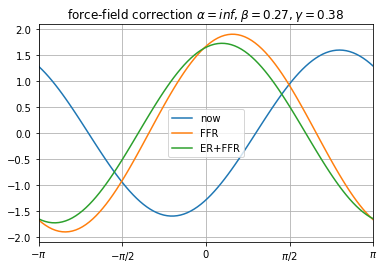

In [72]:
angles = np.linspace(-np.pi, np.pi, 100)

plt.figure()
deltaV = {}

for s in ['now', 'FFR', 'ER+FFR']:
    deltaV[s] = ff_coeffs[s]['cos alpha']*np.cos(angles) + ff_coeffs[s]['sin alpha']*np.sin(angles)

    plt.plot(angles, deltaV[s], '-', label=s)

plt.legend()
plt.grid()
plt.title(r'force-field correction $\alpha=%.2f,\beta=%.2f,\gamma=%.2f$' % (opt_alpha, opt_beta, opt_gamma))

plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
plt.xlim([-np.pi, np.pi])

In [73]:
s = 'AAAA'

i = 2

angles = np.arcsin(data[s].f[:, i])
wh = np.argwhere(data[s].f[:, i + 6] < 0)
angles[wh] = np.pi - angles[wh]
angles = np.mod(angles, 2*np.pi)

wh = np.argwhere((angles > np.pi) & (angles < 2*np.pi))
angles[wh] = angles[wh] - 2*np.pi

angles

array([-1.43053038, -1.2610528 , -1.68009641, ...,  1.72666202,
       -1.41438142, -1.26707563])

In [196]:
angles = data['AAAA'].forward_qs['backbone1_gamma'][:, 0]

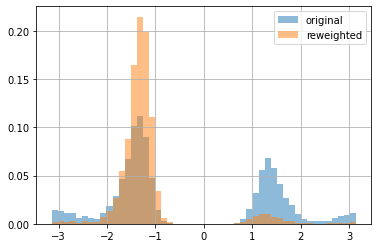

In [74]:
plt.hist(angles, weights=data[s].weights, bins=50, alpha=0.5, label='original')[1]
plt.hist(angles, weights=Result.weights_new[s], bins=50, alpha=0.5, label='reweighted')[1]
plt.grid()
plt.legend()

In [124]:
vars(Result).keys()

dict_keys(['loss', 'pars', 'mini', 'min_lambdas', 'minis', 'intermediates', 'time', 'weights_P', 'logZ_P', 'reg_ff', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])

In [146]:
Result.D_KL_alpha

AttributeError: 'Result_class' object has no attribute 'D_KL_alpha'

In [147]:
Result.reg_ff

{'AAAA': DeviceArray(0.35721436, dtype=float64),
 'CAAU': DeviceArray(0.36532376, dtype=float64),
 'CCCC': DeviceArray(0.3314244, dtype=float64),
 'GACC': DeviceArray(0.28684363, dtype=float64),
 'UUUU': DeviceArray(0.28652552, dtype=float64),
 'UCAAUC': DeviceArray(2.3386978, dtype=float64)}

so, the ensemble changes very little: what matters mostly is the forward model!

##### forward model

In [20]:
fm_coeffs_0

0
A_gamma     9.70
B_gamma    -1.80
C_gamma     0.00
A_beta     15.30
B_beta     -6.10
C_beta      1.60
A_sugar     9.67
B_sugar    -2.03
C_sugar     0.00
Name: 1, dtype: float64

In [23]:
fm_coeffs['original']

0
A_gamma     9.70
B_gamma    -1.80
C_gamma     0.00
A_beta     15.30
B_beta     -6.10
C_beta      1.60
A_sugar     9.67
B_sugar    -2.03
C_sugar     0.00
Name: 1, dtype: float64

In [75]:
fm_coeffs_0 = pandas.read_csv('Results/original_fm_coeffs', index_col=0, header=None)[1]
fm_coeffs_Thorben = pandas.read_csv('Results/fm_coeffs_Thorben_ref', index_col=0, header=None)[1]

# hyperparameters derived by Thorben with chi2 and chi2 + R regularizations respectively
mini1_hyperpars = {'alpha': 85.3167852417281, 'beta': 0.019306977288832506*2}
mini2_hyperpars = {'alpha': 174.33288221999874, 'beta': 3.433320018281997*2} # those for fm_coeffs_Thorben

fm_coeffs = {}
fm_coeffs['original'] = fm_coeffs_0
fm_coeffs['Thorben'] = fm_coeffs_Thorben
fm_coeffs['mine'] = my_fm_coeffs

print(fm_coeffs)

{'original': 0
A_gamma     9.70
B_gamma    -1.80
C_gamma     0.00
A_beta     15.30
B_beta     -6.10
C_beta      1.60
A_sugar     9.67
B_sugar    -2.03
C_sugar     0.00
Name: 1, dtype: float64, 'Thorben': 0
A_gamma    10.07
B_gamma    -1.87
C_gamma    -0.13
A_beta     18.34
B_beta     -5.39
C_beta      0.11
A_sugar     7.81
B_sugar    -2.05
C_sugar     0.25
Name: 1, dtype: float64, 'mine': A_gamma     9.776437
B_gamma    -1.535660
C_gamma    -0.145552
A_beta     17.761679
B_beta     -5.362363
C_beta      0.171249
A_sugar     6.204327
B_sugar    -1.672162
C_sugar     1.090051
dtype: float64}


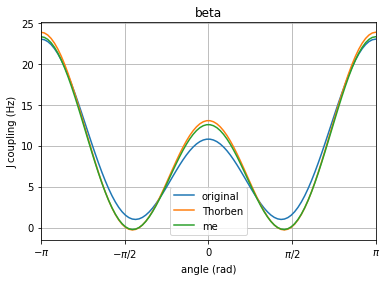

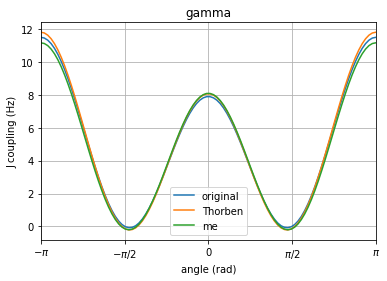

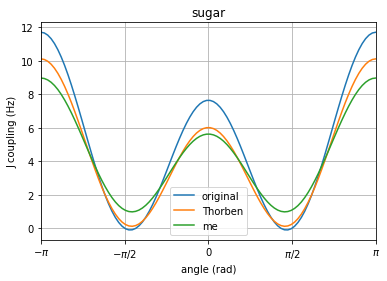

In [77]:
compute_deltaV = lambda fm_coeffs, angles, s: fm_coeffs['A_' + s]*np.cos(angles)**2 + fm_coeffs['B_' + s]*np.cos(angles) + fm_coeffs['C_' + s]*np.ones(len(angles))

angles = np.linspace(-np.pi, np.pi, 100)

for i,s in enumerate(['beta', 'gamma', 'sugar']):

    plt.figure()

    deltaV = {}

    deltaV = compute_deltaV(fm_coeffs['original'], angles, s)
    plt.plot(angles, deltaV, '-', label='original')

    deltaV = compute_deltaV(fm_coeffs['Thorben'], angles, s)
    plt.plot(angles, deltaV, '-', label='Thorben')

    deltaV = compute_deltaV(fm_coeffs['mine'], angles, s) #  ['mean'], angles, s)
    plt.plot(angles, deltaV, '-', label='me') #   (average)')

    # for j in range(n_seeds):
    #     deltaV = compute_deltaV(fm_coeffs['mine'][j], angles, s)
    #     plt.plot(angles, deltaV, '-', color='tab:red')#, label='av. mine')


    # for k in ['original', 'mini2', 'mine']:
    #     deltaV[k] = fm_coeffs[k]['A_' + s]*np.cos(angles)**2 + fm_coeffs[k]['B_' + s]*np.cos(
    #         angles) + fm_coeffs[k]['C_' + s]*np.ones(len(angles))

    #     plt.plot(angles, deltaV[k], '-', label=k)
    
    plt.grid()
    plt.xlabel('angle (rad)')
    plt.title(s)
    plt.xlim([-np.pi, np.pi])
    plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-\pi$', r'$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

    plt.legend()
    plt.ylabel('J coupling (Hz)')

# plt.savefig('../Figures/Karplus_refinement_%.0f_%.0f.png' % (opt_alpha, opt_gamma))
plt.show()

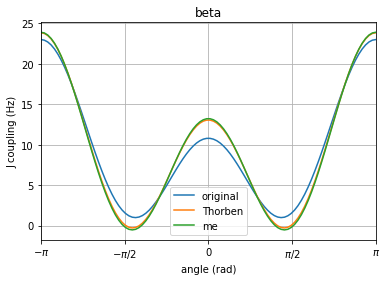

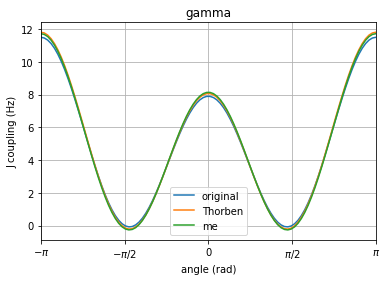

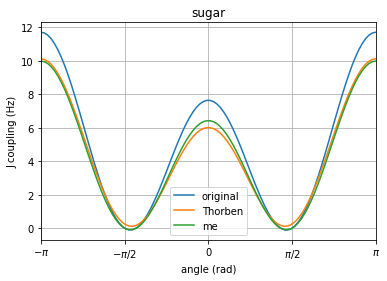

In [91]:
compute_deltaV = lambda fm_coeffs, angles, s: fm_coeffs['A_' + s]*np.cos(angles)**2 + fm_coeffs['B_' + s]*np.cos(angles) + fm_coeffs['C_' + s]*np.ones(len(angles))

angles = np.linspace(-np.pi, np.pi, 100)

for i,s in enumerate(['beta', 'gamma', 'sugar']):

    plt.figure()

    deltaV = {}

    deltaV = compute_deltaV(fm_coeffs['original'], angles, s)
    plt.plot(angles, deltaV, '-', label='original')

    deltaV = compute_deltaV(fm_coeffs['mini2'], angles, s)
    plt.plot(angles, deltaV, '-', label='Thorben')

    deltaV = compute_deltaV(fm_coeffs['mine'], angles, s) #  ['mean'], angles, s)
    plt.plot(angles, deltaV, '-', label='me') #   (average)')

    # for j in range(n_seeds):
    #     deltaV = compute_deltaV(fm_coeffs['mine'][j], angles, s)
    #     plt.plot(angles, deltaV, '-', color='tab:red')#, label='av. mine')


    # for k in ['original', 'mini2', 'mine']:
    #     deltaV[k] = fm_coeffs[k]['A_' + s]*np.cos(angles)**2 + fm_coeffs[k]['B_' + s]*np.cos(
    #         angles) + fm_coeffs[k]['C_' + s]*np.ones(len(angles))

    #     plt.plot(angles, deltaV[k], '-', label=k)
    
    plt.grid()
    plt.xlabel('angle (rad)')
    plt.title(s)
    plt.xlim([-np.pi, np.pi])
    plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-\pi$', r'$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

    plt.legend()
    plt.ylabel('J coupling (Hz)')

# plt.savefig('../Figures/Karplus_refinement_%.0f_%.0f.png' % (opt_alpha, opt_gamma))
plt.show()

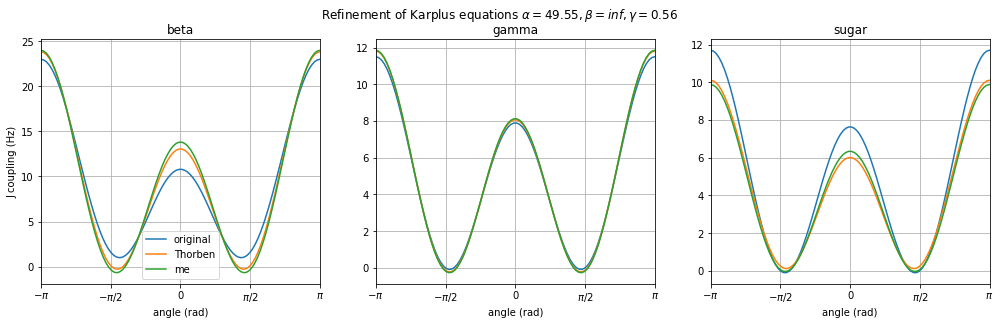

In [105]:
fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(4.5)
fig.set_figwidth(17)

compute_deltaV = lambda fm_coeffs, angles, s: fm_coeffs['A_' + s]*np.cos(angles)**2 + fm_coeffs['B_' + s]*np.cos(angles) + fm_coeffs['C_' + s]*np.ones(len(angles))

plt.suptitle(r'Refinement of Karplus equations $\alpha=%.2f,\beta=%.2f,\gamma=%.2f$' % (opt_alpha, opt_beta, opt_gamma))

angles = np.linspace(-np.pi, np.pi, 100)

for i,s in enumerate(['beta', 'gamma', 'sugar']):

    deltaV = {}

    deltaV = compute_deltaV(fm_coeffs['original'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='original')

    deltaV = compute_deltaV(fm_coeffs['mini2'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='Thorben')

    deltaV = compute_deltaV(fm_coeffs['mine'], angles, s) #  ['mean'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='me') #   (average)')

    # for j in range(n_seeds):
    #     deltaV = compute_deltaV(fm_coeffs['mine'][j], angles, s)
    #     axs[i].plot(angles, deltaV, '-', color='tab:red')#, label='av. mine')


    # for k in ['original', 'mini2', 'mine']:
    #     deltaV[k] = fm_coeffs[k]['A_' + s]*np.cos(angles)**2 + fm_coeffs[k]['B_' + s]*np.cos(
    #         angles) + fm_coeffs[k]['C_' + s]*np.ones(len(angles))

    #     axs[i].plot(angles, deltaV[k], '-', label=k)
    
    axs[i].grid()
    axs[i].set_xlabel('angle (rad)')
    axs[i].set_title(s)
    axs[i].set_xlim([-np.pi, np.pi])
    axs[i].set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    axs[i].set_xticklabels([r'$-\pi$', r'$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

axs[0].legend()
axs[0].set_ylabel('J coupling (Hz)')

# plt.savefig('../Figures/Karplus_refinement_%.0f_%.0f.png' % (opt_alpha, opt_gamma))
plt.show()

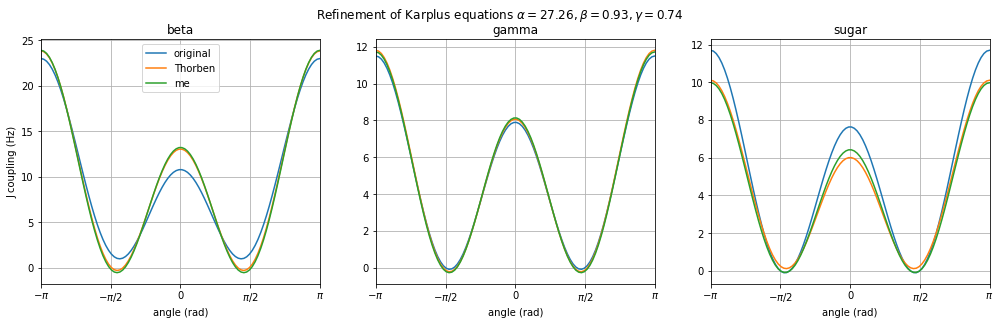

In [89]:
fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(4.5)
fig.set_figwidth(17)

compute_deltaV = lambda fm_coeffs, angles, s: fm_coeffs['A_' + s]*np.cos(angles)**2 + fm_coeffs['B_' + s]*np.cos(angles) + fm_coeffs['C_' + s]*np.ones(len(angles))

plt.suptitle(r'Refinement of Karplus equations $\alpha=%.2f,\beta=%.2f,\gamma=%.2f$' % (opt_alpha, opt_beta, opt_gamma))

angles = np.linspace(-np.pi, np.pi, 100)

for i,s in enumerate(['beta', 'gamma', 'sugar']):

    deltaV = {}

    deltaV = compute_deltaV(fm_coeffs['original'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='original')

    deltaV = compute_deltaV(fm_coeffs['mini2'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='Thorben')

    deltaV = compute_deltaV(fm_coeffs['mine'], angles, s) #  ['mean'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='me') #   (average)')

    # for j in range(n_seeds):
    #     deltaV = compute_deltaV(fm_coeffs['mine'][j], angles, s)
    #     axs[i].plot(angles, deltaV, '-', color='tab:red')#, label='av. mine')


    # for k in ['original', 'mini2', 'mine']:
    #     deltaV[k] = fm_coeffs[k]['A_' + s]*np.cos(angles)**2 + fm_coeffs[k]['B_' + s]*np.cos(
    #         angles) + fm_coeffs[k]['C_' + s]*np.ones(len(angles))

    #     axs[i].plot(angles, deltaV[k], '-', label=k)
    
    axs[i].grid()
    axs[i].set_xlabel('angle (rad)')
    axs[i].set_title(s)
    axs[i].set_xlim([-np.pi, np.pi])
    axs[i].set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    axs[i].set_xticklabels([r'$-\pi$', r'$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

axs[0].legend()
axs[0].set_ylabel('J coupling (Hz)')

# plt.savefig('../Figures/Karplus_refinement_%.0f_%.0f.png' % (opt_alpha, opt_gamma))
plt.show()

Text(0, 0.5, 'J coupling (Hz)')

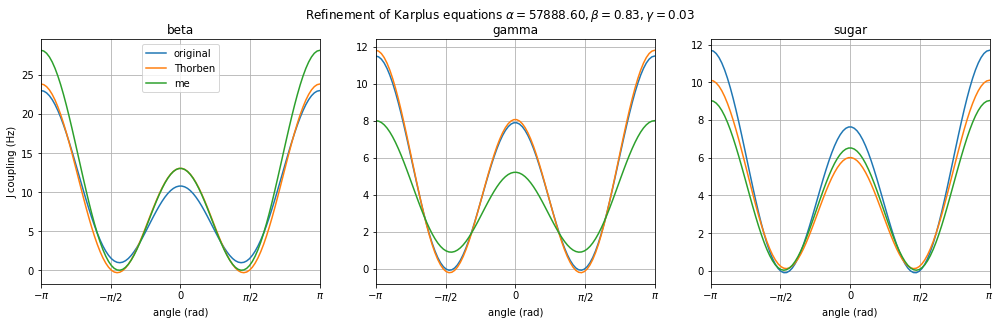

In [105]:
fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(4.5)
fig.set_figwidth(17)

compute_deltaV = lambda fm_coeffs, angles, s: fm_coeffs['A_' + s]*np.cos(angles)**2 + fm_coeffs['B_' + s]*np.cos(angles) + fm_coeffs['C_' + s]*np.ones(len(angles))

plt.suptitle(r'Refinement of Karplus equations $\alpha=%.2f,\beta=%.2f,\gamma=%.2f$' % (opt_alpha, opt_beta, opt_gamma))

angles = np.linspace(-np.pi, np.pi, 100)

for i,s in enumerate(['beta', 'gamma', 'sugar']):

    deltaV = {}

    deltaV = compute_deltaV(fm_coeffs['original'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='original')

    deltaV = compute_deltaV(fm_coeffs['mini2'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='Thorben')

    deltaV = compute_deltaV(fm_coeffs['mine'], angles, s) #  ['mean'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='me') #   (average)')

    # for j in range(n_seeds):
    #     deltaV = compute_deltaV(fm_coeffs['mine'][j], angles, s)
    #     axs[i].plot(angles, deltaV, '-', color='tab:red')#, label='av. mine')


    # for k in ['original', 'mini2', 'mine']:
    #     deltaV[k] = fm_coeffs[k]['A_' + s]*np.cos(angles)**2 + fm_coeffs[k]['B_' + s]*np.cos(
    #         angles) + fm_coeffs[k]['C_' + s]*np.ones(len(angles))

    #     axs[i].plot(angles, deltaV[k], '-', label=k)
    
    axs[i].grid()
    axs[i].set_xlabel('angle (rad)')
    axs[i].set_title(s)
    axs[i].set_xlim([-np.pi, np.pi])
    axs[i].set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    axs[i].set_xticklabels([r'$-\pi$', r'$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

axs[0].legend()
axs[0].set_ylabel('J coupling (Hz)')

# plt.show()
# plt.savefig('../Figures/Karplus_refinement_%.0f_%.0f.png' % (opt_alpha, opt_gamma))

Text(0, 0.5, 'J coupling (Hz)')

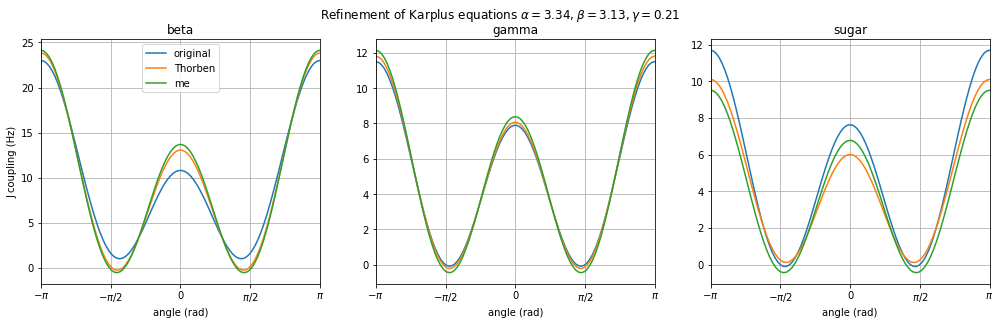

In [54]:
fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(4.5)
fig.set_figwidth(17)

compute_deltaV = lambda fm_coeffs, angles, s: fm_coeffs['A_' + s]*np.cos(angles)**2 + fm_coeffs['B_' + s]*np.cos(angles) + fm_coeffs['C_' + s]*np.ones(len(angles))

plt.suptitle(r'Refinement of Karplus equations $\alpha=%.2f,\beta=%.2f,\gamma=%.2f$' % (opt_alpha, opt_beta, opt_gamma))

angles = np.linspace(-np.pi, np.pi, 100)

for i,s in enumerate(['beta', 'gamma', 'sugar']):

    deltaV = {}

    deltaV = compute_deltaV(fm_coeffs['original'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='original')

    deltaV = compute_deltaV(fm_coeffs['mini2'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='Thorben')

    deltaV = compute_deltaV(fm_coeffs['mine'], angles, s) #  ['mean'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='me') #   (average)')

    # for j in range(n_seeds):
    #     deltaV = compute_deltaV(fm_coeffs['mine'][j], angles, s)
    #     axs[i].plot(angles, deltaV, '-', color='tab:red')#, label='av. mine')


    # for k in ['original', 'mini2', 'mine']:
    #     deltaV[k] = fm_coeffs[k]['A_' + s]*np.cos(angles)**2 + fm_coeffs[k]['B_' + s]*np.cos(
    #         angles) + fm_coeffs[k]['C_' + s]*np.ones(len(angles))

    #     axs[i].plot(angles, deltaV[k], '-', label=k)
    
    axs[i].grid()
    axs[i].set_xlabel('angle (rad)')
    axs[i].set_title(s)
    axs[i].set_xlim([-np.pi, np.pi])
    axs[i].set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    axs[i].set_xticklabels([r'$-\pi$', r'$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

axs[0].legend()
axs[0].set_ylabel('J coupling (Hz)')

# plt.show()
# plt.savefig('../Figures/Karplus_refinement_%.0f_%.0f.png' % (opt_alpha, opt_gamma))